In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py
import os
import time

from datasets import GoogleTinyAES
from leakage_detectors.non_learning import get_trace_means, get_sum_of_differences, get_signal_to_noise_ratio

/home/min/a/jgammell/miniconda3/envs/sca-defense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = GoogleTinyAES()
print(dataset)

class RandomNoiseDataset:
    def __init__(self):
        self.traces = np.random.randn(len(dataset), *dataset.data_shape)
        self.labels = np.random.randint(256, size=(len(dataset),)).astype(np.uint8)
        self.data_shape = dataset.data_shape
    
    def __getitem__(self, idx):
        return self.traces[idx], self.labels[idx]
    
    def get_trace(self, idx, ret_targets=False):
        return self.traces[idx], self.labels[idx]
        
    def __len__(self):
        return len(self.traces)

random_noise_dataset = RandomNoiseDataset()

GoogleTinyAES(
	resource_path=../resources/google_tinyaes/datasets/tinyaes/train/data.hdf5,
	store_in_ram=False,
	train=True,
	data_transform=None,
	target_transform=None,
	target_variables=['sub_bytes_in'],
	target_bytes=[0]
)


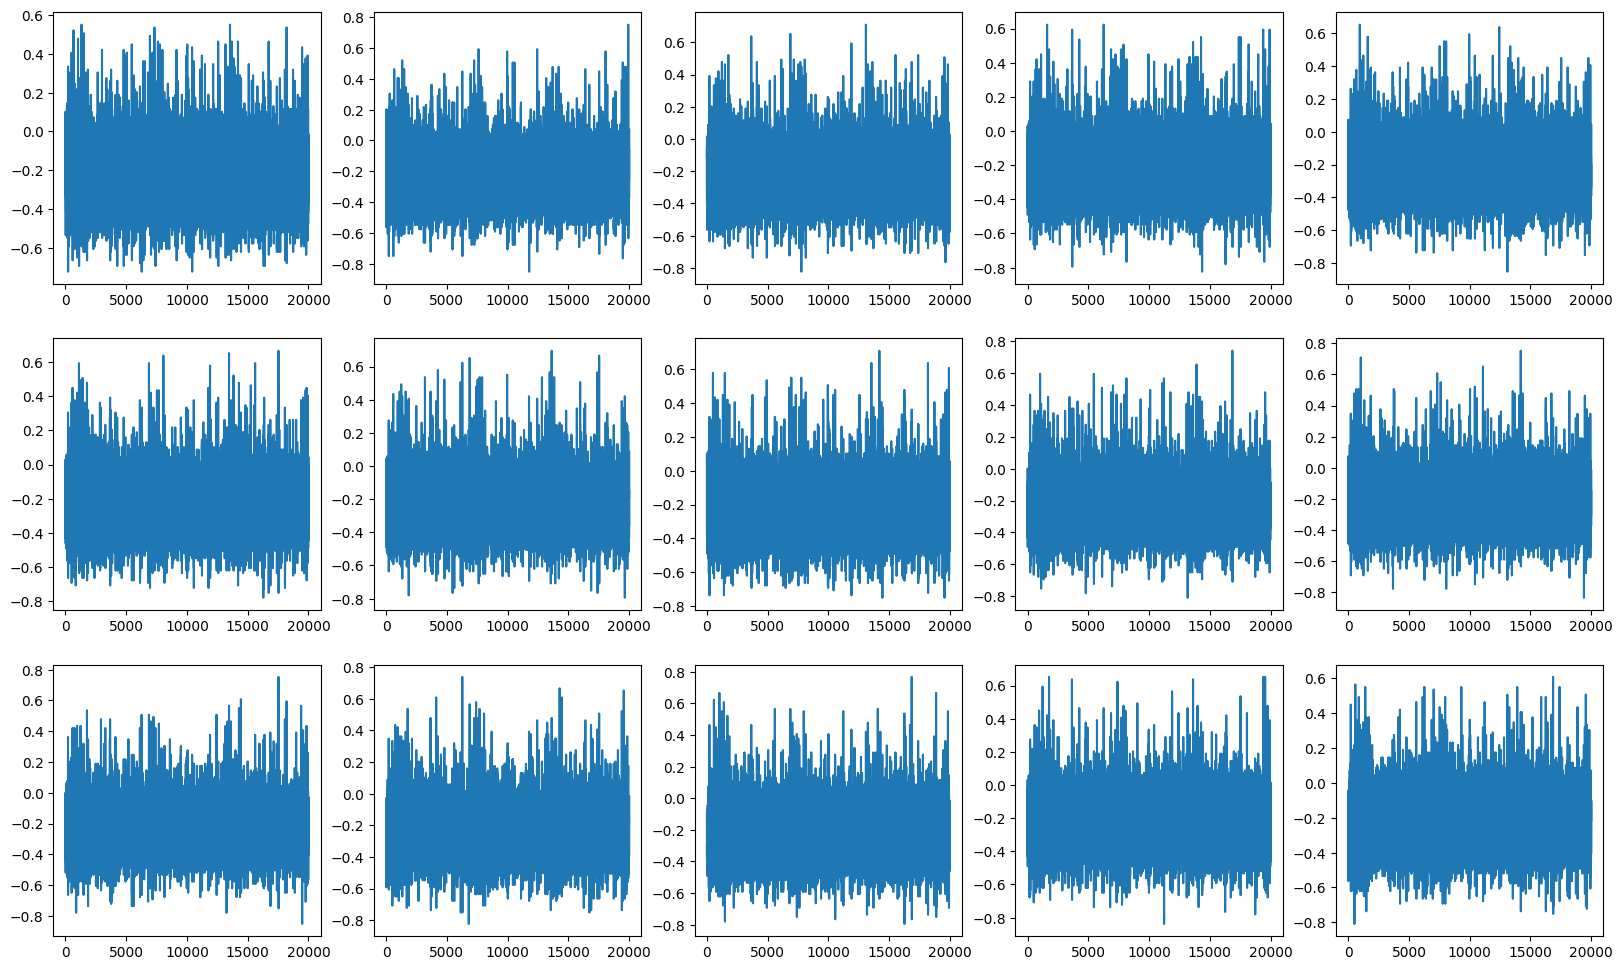

In [3]:
%matplotlib inline
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for idx, ax in enumerate(axes.flatten()):
    trace, _ = dataset[idx]
    trace = trace.squeeze()
    ax.plot(trace)

In [4]:
mean, var = np.zeros_like(trace), np.zeros_like(trace)
for idx, (trace, _) in enumerate(tqdm(dataset)):
    mean = (1/(idx+1))*trace.squeeze() + (idx/(idx+1))*mean
for idx, (trace, _) in enumerate(tqdm(dataset)):
    var = (1/(idx+1))*(trace.squeeze() - mean)**2 + (idx/(idx+1))*var
stdev = np.sqrt(var)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [00:33<00:00, 1980.08it/s]


Text(0, 0.5, 'Std. deviation')

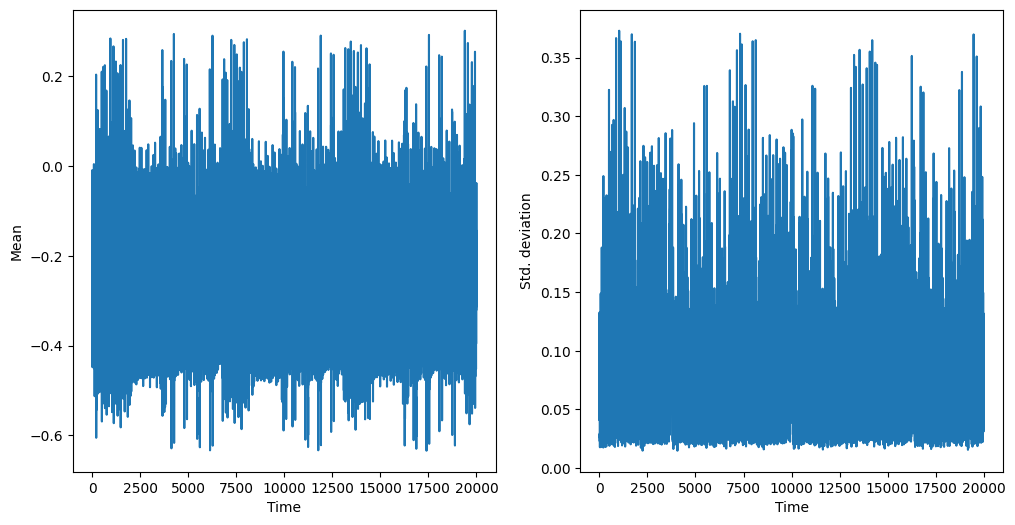

In [5]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(mean)
axes[1].plot(stdev)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mean')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Std. deviation')

In [6]:
trace_means = get_trace_means(dataset)
snr_mask = get_signal_to_noise_ratio(dataset, trace_means=trace_means)
random_means = get_trace_means(random_noise_dataset)
rand_snr_mask = get_signal_to_noise_ratio(random_noise_dataset, trace_means=random_means)

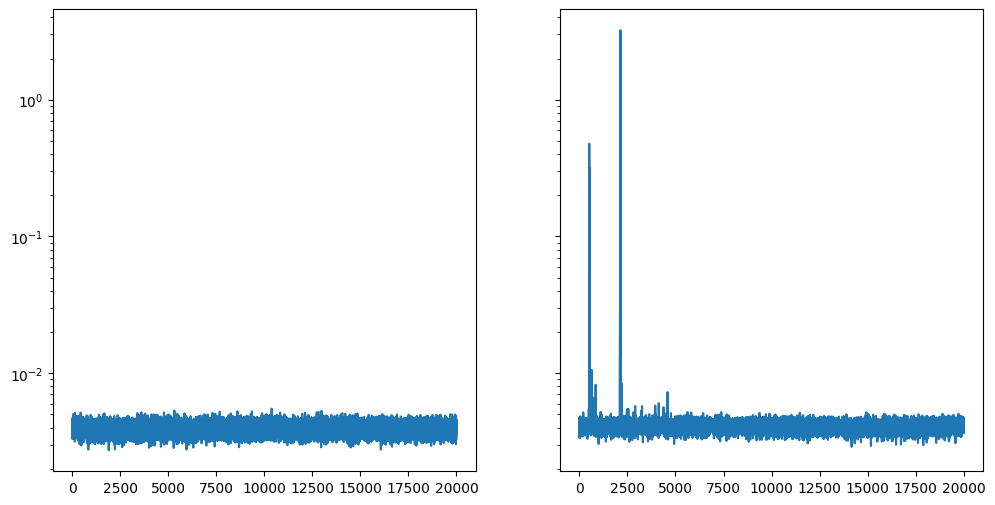

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].plot(rand_snr_mask.squeeze())
axes[1].plot(snr_mask.squeeze())
axes[0].set_yscale('log')
axes[1].set_yscale('log')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:06<00:00, 54.45s/it]

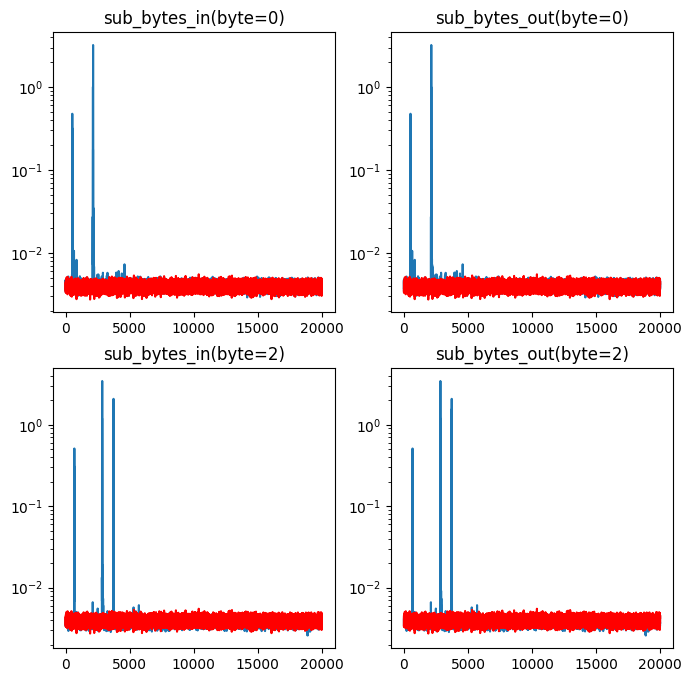

In [8]:
%matplotlib inline
target_variables = ['sub_bytes_in', 'sub_bytes_out']
target_bytes = [0, 2]
fig, axes = plt.subplots(len(target_bytes), len(target_variables), figsize=(4*len(target_variables), 4*len(target_bytes)))
progress_bar = tqdm(total=len(target_bytes)*len(target_variables))

for tb_idx, target_byte in enumerate(target_bytes):
    axes_r = axes[tb_idx, :]
    for tv_idx, target_variable in enumerate(target_variables):
        dataset.select_target(variables=target_variable, bytes=target_byte)
        ax = axes_r[tv_idx]
        snr_mask = get_signal_to_noise_ratio(dataset).squeeze()
        ax.plot(snr_mask)
        ax.plot(rand_snr_mask.squeeze(), color='red')
        ax.set_title(f'{target_variable}(byte={target_byte})')
        ax.set_yscale('log')
        progress_bar.update(1)

8it [06:40, 40.86s/it]                                                                                                                                                             

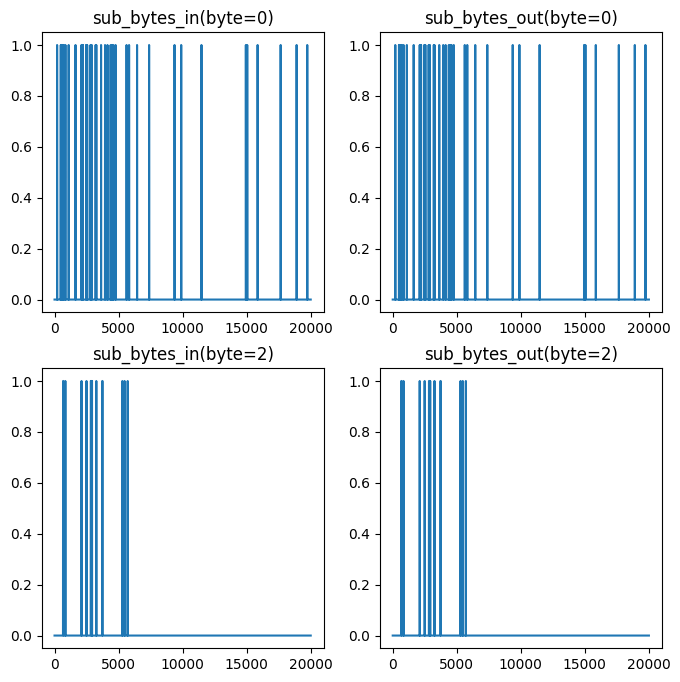

In [9]:
%matplotlib inline
from scipy.stats import norm
loc, scale = norm.fit(rand_snr_mask.squeeze())

fig, axes = plt.subplots(len(target_bytes), len(target_variables), figsize=(4*len(target_variables), 4*len(target_bytes)))
for tb_idx, target_byte in enumerate(target_bytes):
    axes_r = axes[tb_idx, :]
    for tv_idx, target_variable in enumerate(target_variables):
        dataset.select_target(variables=target_variable, bytes=target_byte)
        ax = axes_r[tv_idx]
        snr_mask = get_signal_to_noise_ratio(dataset).squeeze()
        ax.plot(norm.sf(snr_mask, loc=loc, scale=scale)<1e-3)
        ax.set_title(f'{target_variable}(byte={target_byte})')
        progress_bar.update(1)